In [65]:
#import modules
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gsw
from pkg_resources import non_empty_lines
import os
import glob
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import re

In [66]:
data_dir = '/Users/iw2g24/PycharmProjects/COOKIES/Data/'
dtc_data = data_dir+ 'DTC/'

# Load only the first 10 data rows (excludes header row from the count)
df = pd.read_csv('/Users/iw2g24/PycharmProjects/COOKIES/Data/DTC/dtc_csv_files/DTC_IN2026_V01_001_20260110T135605Z.CSV', nrows=2)
print(df)



        Alt  Latitude  Longitude  Depth  Temperature  Oxygen  Salinity  \
0  260.7784       NaN        NaN    NaN       1.7759  -5.229      -0.0   
1  265.4475       NaN        NaN    NaN       1.7757  -5.229      -0.0   

                          Date  
0  2026-01-10T13:56:05.000000Z  
1  2026-01-10T13:56:06.000000Z  


In [67]:
# import os
# import re
# import pandas as pd
# import xarray as xr
#
# # Directories
# data_dir = '/Users/iw2g24/PycharmProjects/COOKIES/Data/DTC/'
# dtc_data = os.path.join(data_dir, 'dtc_csv_files/')
# output_dir = os.path.join(data_dir, 'dtc_nc_files')
# os.makedirs(output_dir, exist_ok=True)
#
# # Regex to extract station number
# pattern = r"_([0-9]{3})_"
#
# for filename in os.listdir(dtc_data):
#     if filename.endswith("_CTD.CSV"):
#         file_path = os.path.join(dtc_data, filename)
#
#         # Extract station number
#         match = re.search(pattern, filename)
#         if not match:
#             print(f"Skipping {filename}: no station number found")
#             continue
#
#         stn_number = match.group(1)
#
#         # -------------------------
#         # Load CSV
#         # -------------------------
#         df = pd.read_csv(file_path)
#
#         # Clean column names (remove hidden spaces)
#         df.columns = df.columns.str.strip()
#
#         # -------------------------
#         # Convert timestamp column
#         # -------------------------
#         df["timestamp"] = pd.to_datetime(
#         df["timestamp"],
#         format="mixed",
#         utc=True)
#
#
#         # Set time index
#         df = df.set_index("timestamp")
#         df.index.name = "time"
#
#         # -------------------------
#         # Convert to xarray Dataset
#         # -------------------------
#         ds = xr.Dataset.from_dataframe(df)
#
#         # Ensure proper datetime64[ns] type
#         ds = ds.assign_coords(time=pd.to_datetime(ds.time.values))
#
#         # -------------------------
#         # Add variable attributes
#         # -------------------------
#         ds["sea_water_temperature_celsius"].attrs = {
#             "long_name": "Sea water temperature",
#             "units": "degree_Celsius",
#             "standard_name": "sea_water_temperature"
#         }
#
#         ds["sea_water_electrical_conductivity"].attrs = {
#             "long_name": "Sea water electrical conductivity",
#             "units": "S m-1"
#         }
#
#         ds["sea_water_pressure"].attrs = {
#             "long_name": "Sea water pressure",
#             "units": "dbar",
#             "standard_name": "sea_water_pressure"
#         }
#
#         ds["ml_concentration_of_dissolved_molecular_oxygen_in_seawater"].attrs = {
#             "long_name": "Dissolved molecular oxygen concentration",
#             "units": "ml L-1"
#         }
#
#         ds["sea_water_practical_salinity"].attrs = {
#             "long_name": "Practical salinity",
#             "units": "1",
#             "standard_name": "sea_water_practical_salinity"
#         }
#
#         ds["speed_of_sound_in_sea_water"].attrs = {
#             "long_name": "Speed of sound in sea water",
#             "units": "m s-1"
#         }
#
#         # -------------------------
#         # Global attributes
#         # -------------------------
#         ds.attrs = {
#             "title": "DTC Sensor Data",
#             "station_number": stn_number,
#             "source_file": filename,
#             "institution": "Your Institution Name",
#             "history": "Converted from CSV to NetCDF using pandas and xarray",
#             "time_coverage_start": str(ds.time.min().values),
#             "time_coverage_end": str(ds.time.max().values)
#         }
#
#         # -------------------------
#         # Output filename
#         # -------------------------
#         nc_filename = f"DTC_IN2026_{stn_number}.nc"
#         nc_path = os.path.join(output_dir, nc_filename)
#
#         # Save NetCDF
#         ds.to_netcdf(nc_path)
#
#         print(f"Converted {filename} → {nc_filename}")


In [68]:
data_dtc_test = xr.open_dataset('/Users/iw2g24/PycharmProjects/COOKIES/Data/DTC/dtc_nc_files/DTC_IN2026_011.nc')
print(data_dtc_test.keys())

FileNotFoundError: [Errno 2] No such file or directory: '/Users/iw2g24/PycharmProjects/COOKIES/Data/DTC/dtc_nc_files/DTC_IN2026_011.nc'

In [69]:
data_dir = '/Users/iw2g24/PycharmProjects/COOKIES/Data/DTC/'
dtc_data = os.path.join(data_dir, 'dtc_csv_files/')
nc_dir = os.path.join(data_dir, 'dtc_nc_files')
# Find all NetCDF files
nc_files = sorted(glob.glob(os.path.join(nc_dir, '*.nc')))
print(nc_files)
# Storage for all stations
stations = {}

for f in nc_files:
    ds = xr.open_dataset(f)

    stn = os.path.basename(f).split('_')[-1].split('.')[0]

    # Convert safely (turn '-' into NaN)
    T = pd.to_numeric(ds.sea_water_temperature_celsius.values, errors="coerce")
    S = pd.to_numeric(ds.sea_water_practical_salinity.values, errors="coerce")
    P = pd.to_numeric(ds.sea_water_pressure.values, errors="coerce")
    O = pd.to_numeric(ds.ml_concentration_of_dissolved_molecular_oxygen_in_seawater.values, errors="coerce")

    # Remove NaNs before sorting
    mask = ~np.isnan(P)
    T = T[mask]
    S = S[mask]
    O = O[mask]
    P = P[mask]

    idx = np.argsort(P)

    stations[stn] = {
        "T": T[idx],
        "S": S[idx],
        "O": O[idx],
        "P": P[idx],
    }

    print(f"Loaded station {stn}")


['/Users/iw2g24/PycharmProjects/COOKIES/Data/DTC/dtc_nc_files/DTC_IN2026_012.nc', '/Users/iw2g24/PycharmProjects/COOKIES/Data/DTC/dtc_nc_files/DTC_IN2026_013.nc', '/Users/iw2g24/PycharmProjects/COOKIES/Data/DTC/dtc_nc_files/DTC_IN2026_014.nc', '/Users/iw2g24/PycharmProjects/COOKIES/Data/DTC/dtc_nc_files/DTC_IN2026_015.nc', '/Users/iw2g24/PycharmProjects/COOKIES/Data/DTC/dtc_nc_files/DTC_IN2026_016.nc']
Loaded station 012
Loaded station 013
Loaded station 014
Loaded station 015
Loaded station 016


In [70]:
station_coords = {
    "012": (-64.824574, 132.231512),
    "013": (-64.676571, 132.357958),
    "014": (-64.884571, 131.990534),
    "015": (-65.365653, 132.540655),
    "016": (-65.160155, 132.379628),
    "017": (-64.912285, 132.755691),
}

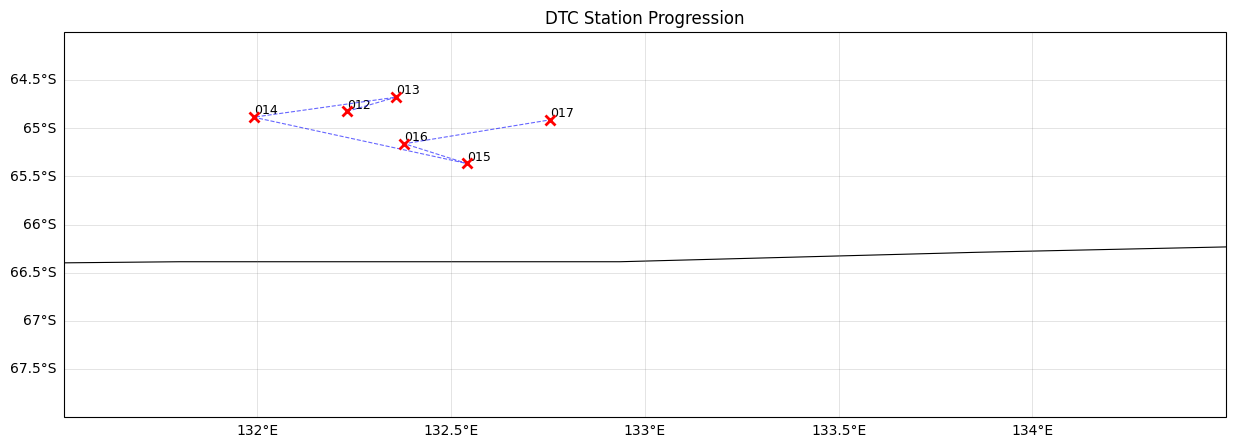

In [72]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

proj = ccrs.PlateCarree()

lon_min, lon_max = 131.5, 134.5
lat_min, lat_max = -68, -64   # (fix order for extent logic)

fig = plt.figure(figsize=(15, 5))
ax = plt.axes(projection=proj)

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax.set_aspect('auto')

# Coastlines
ax.coastlines(resolution='110m', linewidth=0.8)

# -----------------------------------
# Extract station coordinates
# -----------------------------------
lons = []
lats = []
stations_plot = []

for stn in station_coords:

    lat, lon = station_coords[stn]

    # Apply geographic mask
    if (lat_min <= lat <= lat_max) and (lon_min <= lon <= lon_max):
        lons.append(lon)
        lats.append(lat)
        stations_plot.append(stn)

lons = np.array(lons)
lats = np.array(lats)

# -----------------------------------
# Plot connecting line
# -----------------------------------
ax.plot(
    lons,
    lats,
    linestyle='--',
    color='blue',
    linewidth=0.8,
    alpha=0.6,
    transform=ccrs.PlateCarree(),
    zorder=4
)

# -----------------------------------
# Plot station markers
# -----------------------------------
ax.plot(
    lons,
    lats,
    linestyle='None',
    marker='x',
    color='red',
    markersize=7,
    markeredgewidth=2,
    transform=ccrs.PlateCarree(),
    zorder=5
)

# -----------------------------------
# Label stations
# -----------------------------------
for stn, lon, lat in zip(stations_plot, lons, lats):
    ax.text(
        lon,
        lat,
        stn,
        transform=ccrs.PlateCarree(),
        fontsize=9,
        ha='left',
        va='bottom'
    )

# -----------------------------------
# Gridlines
# -----------------------------------
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.3,
    linestyle='-'
)

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title("DTC Station Progression")

plt.show()


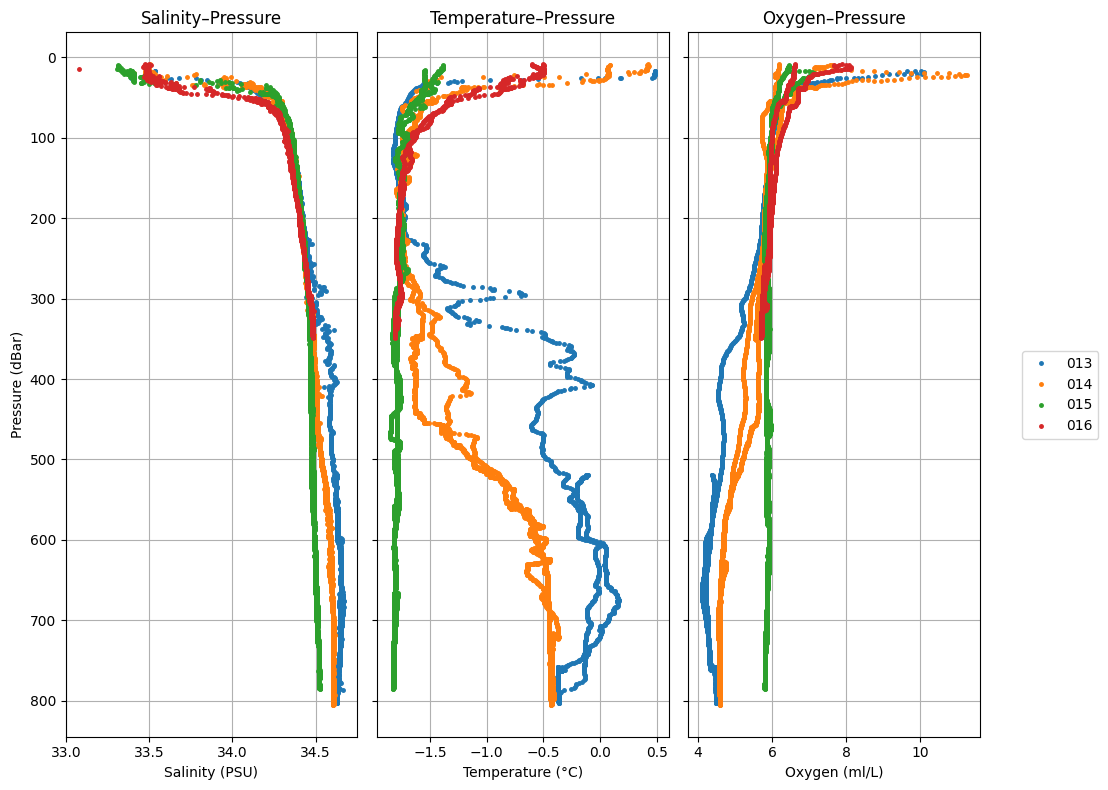

In [73]:
station_ids = list(stations.keys())
selected_stations = station_ids[1:]

fig, axes = plt.subplots(1, 3, figsize=(10, 8), sharey=True)

# --- Salinity ---
ax = axes[0]
for stn in selected_stations:
    data = stations[stn]
    P = data['P']
    mask = P > 8.5
    S = data['S'][mask]
    T = data['T'][mask]
    O = data['O'][mask]
    P = data['P'][mask]
    ax.plot(S, P, '.', markersize=5, label=stn)

ax.invert_yaxis()
ax.set_xlabel("Salinity (PSU)")
ax.set_ylabel("Pressure (dBar)")
ax.set_title("Salinity–Pressure")
ax.grid(True)

# --- Temperature ---
ax = axes[1]
for stn in selected_stations:
    data = stations[stn]
    P = data['P']
    mask = P > 8.5
    S = data['S'][mask]
    T = data['T'][mask]
    O = data['O'][mask]
    P = data['P'][mask]
    ax.plot(T, P, '.', markersize=5, label=stn)

ax.invert_yaxis()
ax.set_xlabel("Temperature (°C)")
ax.set_title("Temperature–Pressure")
ax.grid(True)

# --- Oxygen ---
ax = axes[2]
for stn in selected_stations:
    data = stations[stn]
    P = data['P']
    mask = P > 8.5
    S = data['S'][mask]
    T = data['T'][mask]
    O = data['O'][mask]
    P = data['P'][mask]
    ax.plot(O, P, '.', markersize=5, label=stn)

ax.invert_yaxis()
ax.set_xlabel("Oxygen (ml/L)")
ax.set_title("Oxygen–Pressure")
ax.grid(True)

# Put legend outside the plots
# --- Shared legend ---
fig.legend( labels=selected_stations, loc="center left", bbox_to_anchor=(1.02, 0.5), ncol=1 )

plt.tight_layout()
plt.show()


In [74]:
for stn in stations:
    ds = stations[stn]   # xarray Dataset for this station
    # print(ds.keys())
    # Extract variables
    P = ds['P']
    mask = P > 8.5

    SP = ds['S'][mask]
    temp = ds['T'][mask]
    O = ds['O'][mask]
    pressure = ds['P'][mask]

    lat, lon = station_coords[stn]

    # Compute Absolute Salinity
    SA = gsw.SA_from_SP(SP, pressure, lon, lat)

    # Compute Conservative Temperature
    CT = gsw.CT_from_t(SA, temp, pressure)

    ds["SA"] = xr.DataArray(SA, dims=["time"])
    ds["CT"] = xr.DataArray(CT, dims=["time"])


    # Add metadata
    ds["SA"].attrs = {"long_name": "Absolute Salinity", "units": "g/kg"}
    ds["CT"].attrs = {"long_name": "Conservative Temperature", "units": "degC"}

print("SA and CT computed for all stations.")


SA and CT computed for all stations.


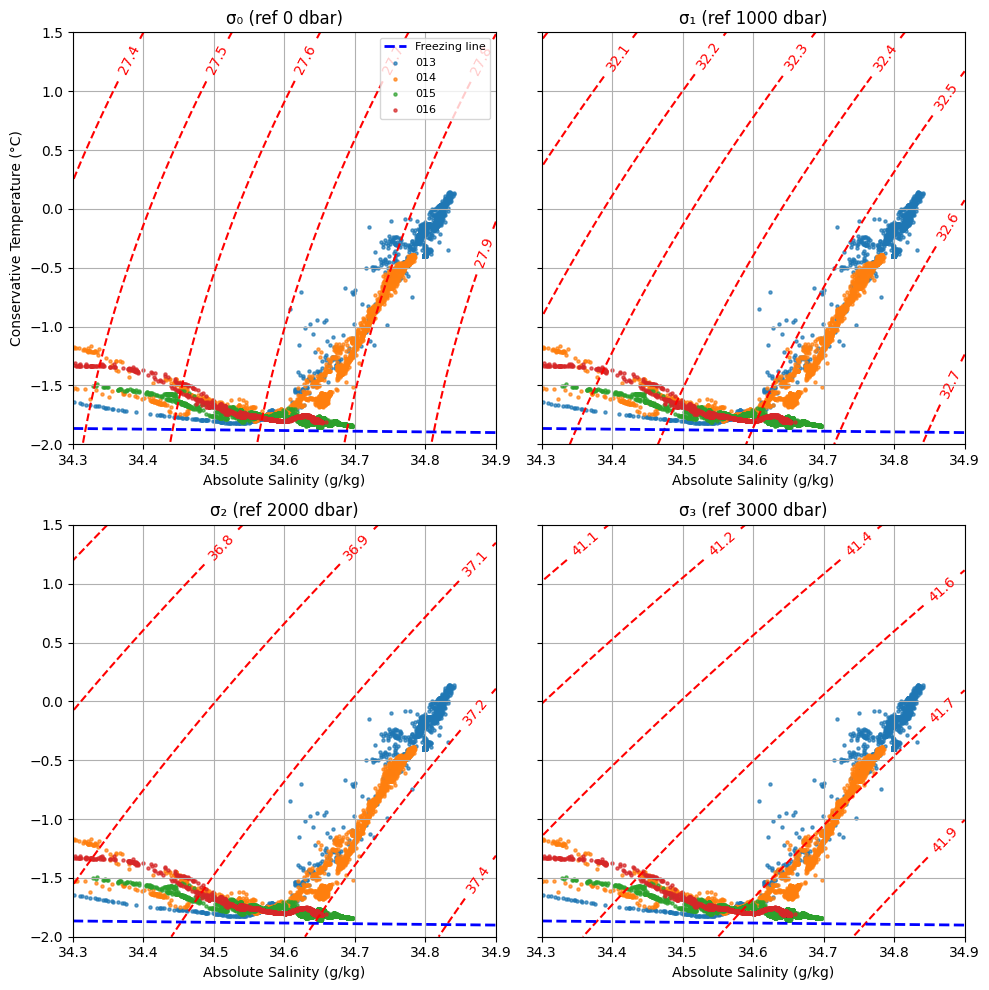

In [75]:

# --- Collect all SA and CT from your stations ---
SA_list = []
CT_list = []

station_ids = list(stations.keys())
selected_stations = station_ids[1:]

for stn in selected_stations:
    ds = stations[stn]

    SA = ds["SA"].values
    CT = ds["CT"].values

    mask = ~np.isnan(SA) & ~np.isnan(CT)
    SA_list.append(SA[mask])
    CT_list.append(CT[mask])

# --- Axis limits ---
xmin = 34.3
xmax = 34.9
ymin = -2
ymax = 1.5

# --- Create grid for isopycnals ---
s_grid = np.linspace(xmin, xmax, 150)
t_grid = np.linspace(ymin, ymax, 150)
Sg, Tg = np.meshgrid(s_grid, t_grid)

sigma0 = gsw.sigma0(Sg, Tg)
sigma1 = gsw.sigma1(Sg, Tg)
sigma2 = gsw.sigma2(Sg, Tg)
sigma3 = gsw.sigma3(Sg, Tg)

sigma_grids = [
    (sigma0, 'σ₀ (ref 0 dbar)'),
    (sigma1, 'σ₁ (ref 1000 dbar)'),
    (sigma2, 'σ₂ (ref 2000 dbar)'),
    (sigma3, 'σ₃ (ref 3000 dbar)')
]

# --- Plot ---
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
axs = axs.flatten()

for ax, (sigma_grid, title) in zip(axs, sigma_grids):

    # Isopycnals
    cs = ax.contour(Sg, Tg, sigma_grid, colors='red', linestyles='--')
    ax.clabel(cs, fmt='%1.1f')

    # Freezing line
    ax.plot(
        s_grid,
        gsw.CT_freezing(s_grid, 0, 0),
        color='blue',
        linewidth=2,
        linestyle='--',
        label='Freezing line'
    )

    # Plot each station
    for i, stn in enumerate(selected_stations):
        ax.scatter(SA_list[i], CT_list[i], s=5, alpha=0.7, label=f"{stn}")

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Absolute Salinity (g/kg)")
    ax.set_title(title)
    ax.grid(True)

axs[0].set_ylabel("Conservative Temperature (°C)")
axs[0].legend(loc="upper right", fontsize=8)

plt.tight_layout()
plt.show()


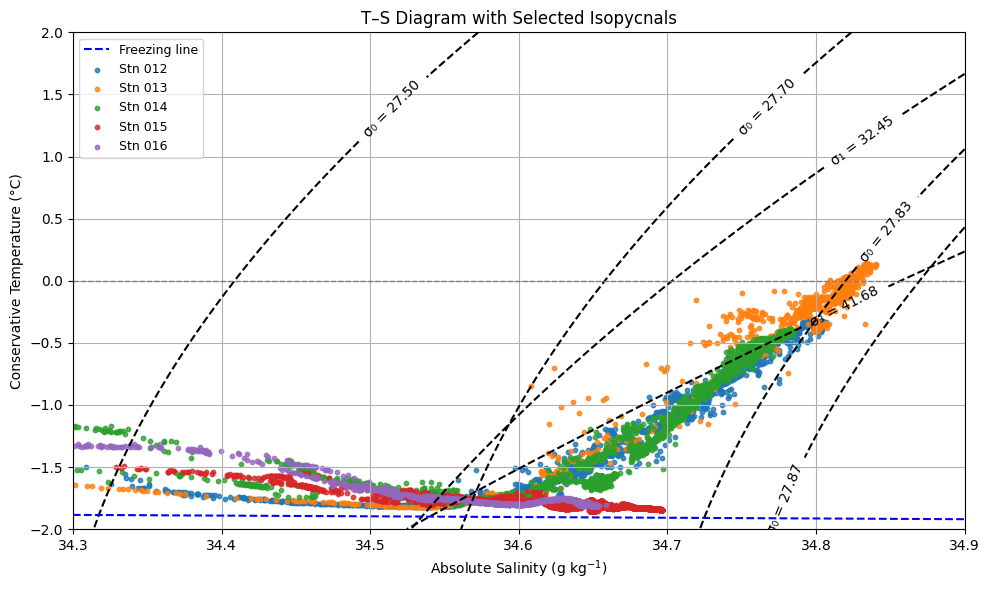

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import gsw

# --- Collect SA and CT for selected stations ---
SA_list = []
CT_list = []

station_ids = list(stations.keys())
selected_stations = station_ids[:]   # skip first if needed

for stn in selected_stations:
    ds = stations[stn]

    SA = ds["SA"].values
    CT = ds["CT"].values

    mask = ~np.isnan(SA) & ~np.isnan(CT)
    SA_list.append(SA[mask])
    CT_list.append(CT[mask])

# --- Axis limits ---
xmin, xmax = 34.3, 34.9
ymin, ymax = -2.0, 2

# --- Density grid ---
s_grid = np.linspace(xmin, xmax, 150)
t_grid = np.linspace(ymin, ymax, 150)
Sg, Tg = np.meshgrid(s_grid, t_grid)

# Explicit isopycnal levels
pd_0 = [27.50, 27.70, 27.83, 27.87]   # sigma-0
pd_1 = [32.45]          # sigma-1
pd_3 = [41.68]          # sigma-3

# Compute density fields
sigma0_grid = gsw.sigma0(Sg, Tg)
sigma1_grid = gsw.sigma1(Sg, Tg)
sigma3_grid = gsw.sigma3(Sg, Tg)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# Sigma-0 contours
cs0 = ax.contour(
    Sg, Tg, sigma0_grid,
    levels=pd_0,
    colors='black',
    linestyles='--',
    linewidths=1.5
)
ax.clabel(cs0, fmt='σ₀ = %.2f')

# Sigma-1 contour
cs1 = ax.contour(
    Sg, Tg, sigma1_grid,
    levels=pd_1,
    colors='black',
    linestyles='--',
    linewidths=1.5
)
ax.clabel(cs1, fmt='σ₁ = %.2f')

# Sigma-3 contour
cs3 = ax.contour(
    Sg, Tg, sigma3_grid,
    levels=pd_3,
    colors='black',
    linestyles='--',
    linewidths=1.5
)
ax.clabel(cs3, fmt='σ₃ = %.2f')

# Freezing line
ax.plot(
    s_grid,
    gsw.CT_freezing(s_grid, 0, 10),  # ~10 dbar
    color='blue',
    linewidth=1.5,
    linestyle='--'
)

# Plot each station
for i, stn in enumerate(selected_stations):
    ax.scatter(
        SA_list[i], CT_list[i],
        s=10,
        alpha=0.8,
        label=f'Stn {stn}'
    )

# Zero-degree line
ax.axhline(0, color='grey', linestyle='--', linewidth=1)

# Formatting
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Absolute Salinity (g kg$^{-1}$)')
ax.set_ylabel('Conservative Temperature (°C)')
ax.set_title('T–S Diagram with Selected Isopycnals')
ax.grid(True)

# Legend
legend_elements = [
    Line2D([0], [0], color='blue', linestyle='--', linewidth=1.5, label='Freezing line')
]

handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles=legend_elements + handles,
    labels=[h.get_label() for h in legend_elements] + labels,
    loc='upper left',
    fontsize=9,
    frameon=True
)

plt.tight_layout()
plt.show()
